
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 4 <br>
<font color=696880 size=4>
<!-- <br> -->


____

# Personal Data

In [1]:
student_number = '400104686'
first_name = 'Parsa'
last_name = 'Yousefpoor'

# Introduction

In this assignment, we will be performing clustering on Spotify songs.

# Data Preprocessing

In the next cell, import the libraries you'll need.

In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
import os

from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/My Drive/IML_4_2")

Mounted at /content/drive


In the `spotify.csv` file, load the data. Exclude unrelated features and retain only the track name and the features you believe are relevant.

In [4]:
usecols = ['track_id','track_name', 'track_artist', 'track_album_id','track_album_name',
                'track_album_release_date', 'playlist_name', 'playlist_id']
df = pd.read_csv('spotify.csv', usecols = usecols)

In this cell, you should implement a standard scalar function from scratch and applying it to your data. Explian importance behind using a standard scalar and the potential complications that could arise in clustering if it's not employed. (you can't use `sklearn.preprocessing.StandardScaler` but you are free to use `sklearn.preprocessing.LabelEncoder`)

**Answer:**

A Standard Scaler is crucial in data preprocessing, especially for machine learning algorithms that are sensitive to the scale of the data, such as PCA, LDA, and k-means clustering. Standard scaling ensures that each feature has a mean of 0 and a standard deviation of 1. This uniformity prevents features with larger scales from dominating the distance calculations and model training.

**Complications Without Standard Scaling:**

1. Bias in Distance-Based Algorithms: Algorithms like k-means clustering rely on distance metrics. Without scaling, features with larger ranges can disproportionately influence the clustering results.
2. Convergence Issues: Gradient-based algorithms might converge more slowly or to suboptimal solutions if the feature scales vary significantly.
3. Model Interpretability: Inconsistent feature scales can complicate the interpretation of model coefficients and predictions.

In [5]:
def standard_scaler(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    scaled_X = (X - mean) / std
    return scaled_X

numeric_features = df.select_dtypes(include=[np.number]).columns
df_scaled = df.copy()
df_scaled[numeric_features] = standard_scaler(df[numeric_features])
print(df_scaled.head())
print("Means of scaled features:\n", df_scaled[numeric_features].mean())
print("\nStandard deviations of scaled features:\n", df_scaled[numeric_features].std())

                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist          track_album_id  \
0        Ed Sheeran  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Justin Bieber) [Loud Luxury...               2019-06-14   
1                    Memories (Dillon Francis Remix)               2019-12

# Dimensionality Reduction

One method for dimensionality reduction is Principal Component Analysis (PCA). Use its implementation from the `sklearn` library to reduce the dimensions of your data. Then, by using an appropriate cut-off for the `_explained_variance_ratio_` in the PCA algorithm, determine the number of principal components to retain.

In [14]:
pca = PCA()
pca.fit(df_scaled[numeric_features])
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
cutoff = 0.95
num_components_to_retain = np.argmax(cumulative_variance_ratio >= cutoff) + 1
print(f"Number of principal components to retain to explain {cutoff*100}% variance: {num_components_to_retain}")
print("Explained variance ratio of each component:\n", explained_variance_ratio)
print("Cumulative explained variance ratio:\n", cumulative_variance_ratio)

Number of principal components to retain to explain 95.0% variance: 8
Explained variance ratio of each component:
 [0.18333504 0.13286557 0.1290332  0.12654588 0.12500806 0.12271985
 0.11304192 0.06745047]
Cumulative explained variance ratio:
 [0.18333504 0.31620062 0.44523381 0.5717797  0.69678776 0.81950761
 0.93254953 1.        ]


# Clustering

Implement K-means for clustering from scratch.

In [17]:
def initialize_centroids(X, k):
    np.random.seed(42)
    random_indices = np.random.permutation(X.shape[0])
    centroids = X[random_indices[:k]]
    return centroids
def compute_distances(X, centroids):
    distances = np.zeros((X.shape[0], len(centroids)))
    for i, centroid in enumerate(centroids):
        distances[:, i] = np.linalg.norm(X - centroid, axis=1)
    return distances
def assign_clusters(distances):
    return np.argmin(distances, axis=1)
def update_centroids(X, labels, k):
    centroids = np.zeros((k, X.shape[1]))
    for i in range(k):
        centroids[i] = X[labels == i].mean(axis=0)
    return centroids
def has_converged(centroids, old_centroids):
    return np.all(centroids == old_centroids)
def kmeans(X, k, max_iters=100):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        old_centroids = centroids
        distances = compute_distances(X, centroids)
        labels = assign_clusters(distances)
        centroids = update_centroids(X, labels, k)
        if has_converged(centroids, old_centroids):
            break
    return labels, centroids

Using the function you've created to execute the K-means algorithm eight times on your data, with the number of clusters ranging from 2 to 9. For each run, display the genre of each cluster using the first two principal components in a plot.

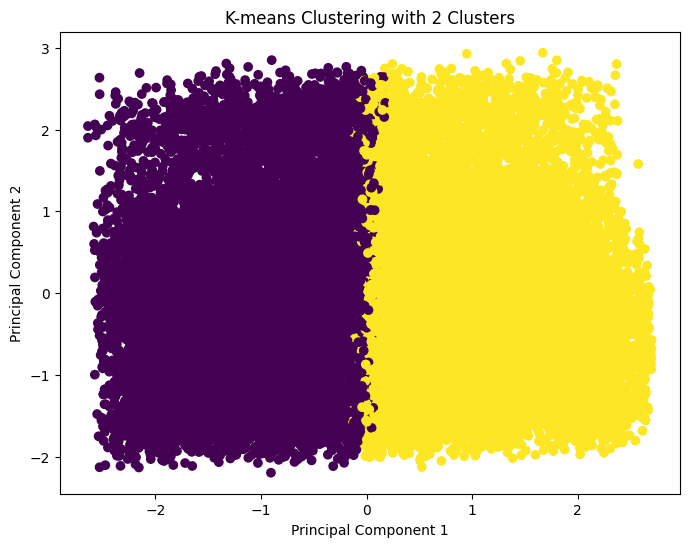

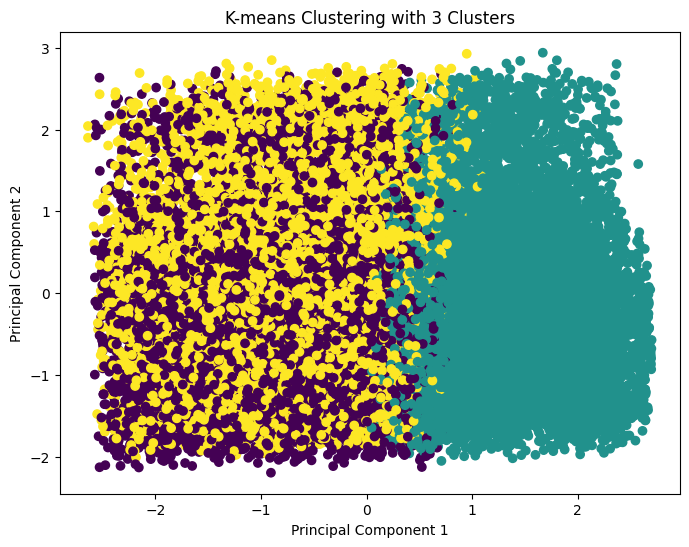

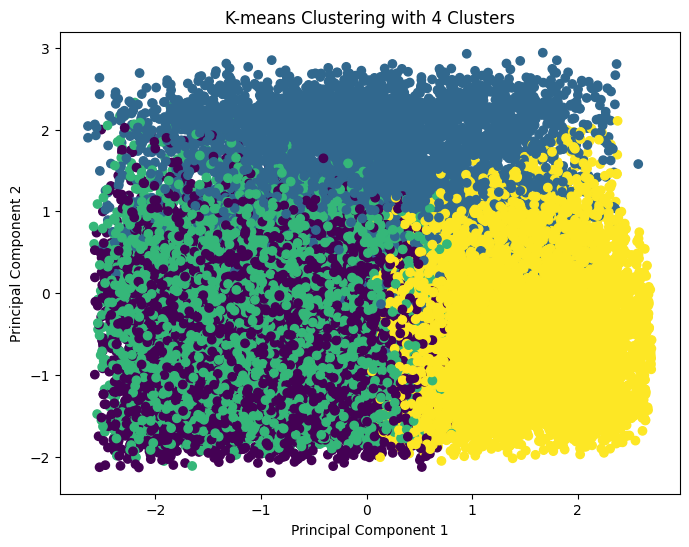

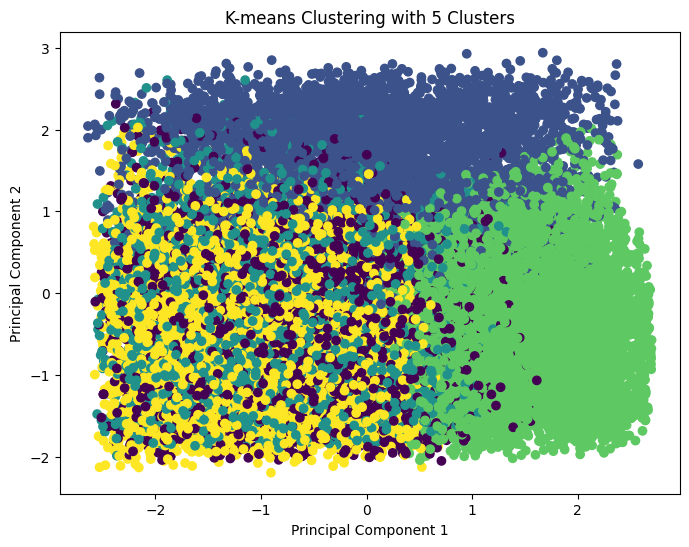

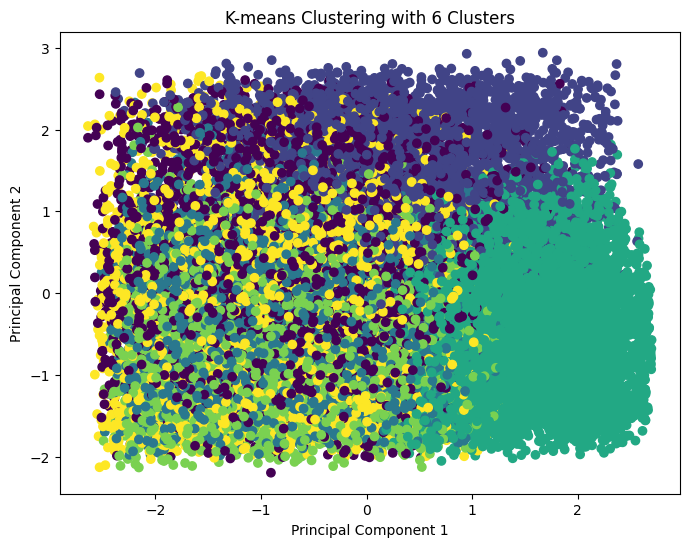

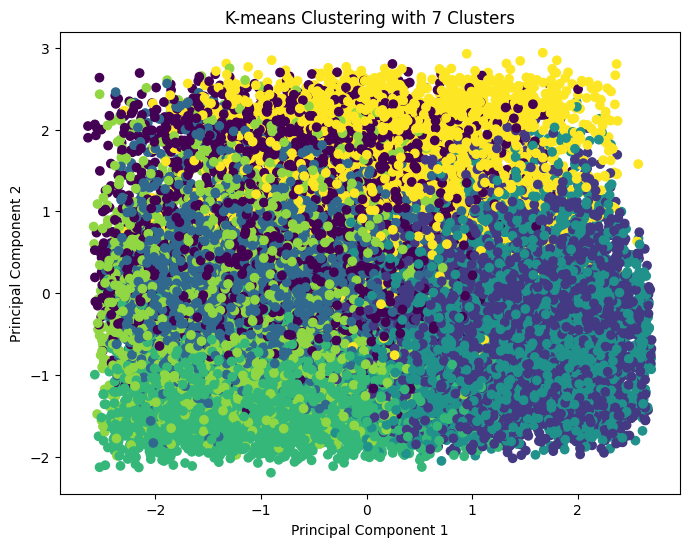

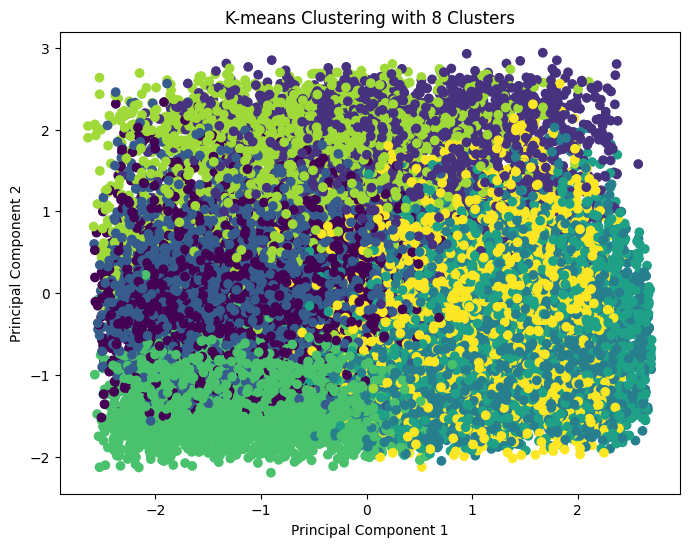

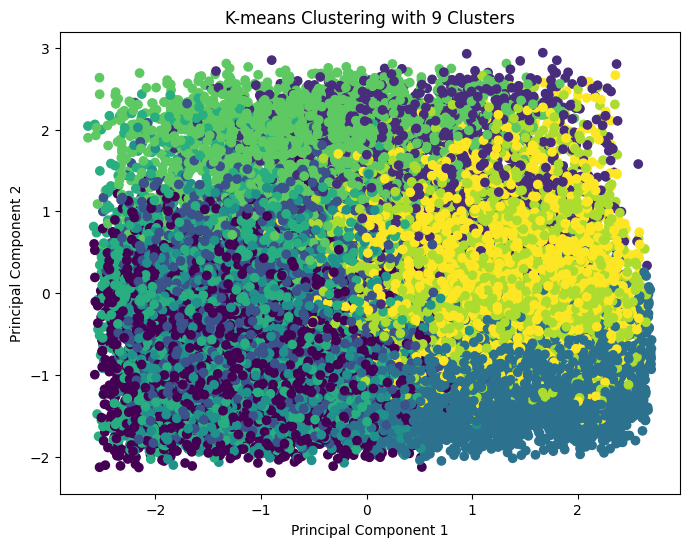

In [18]:
df_pca = pca.transform(df_scaled[numeric_features])[:, :num_components_to_retain]
for k in range(2, 10):
    labels, centroids = kmeans(df_pca, k)
    plt.figure(figsize=(8, 6))
    plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis')
    plt.title(f'K-means Clustering with {k} Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

The Silhouette score and the Within-Cluster Sum of Squares (WSS) score are two metrics used to assess the quality of your clustering. You can find more information about these two methods [here](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb). Plot the Silhouette score and the WSS score for varying numbers of clusters, and use these plots to determine the optimal number of clusters (k).

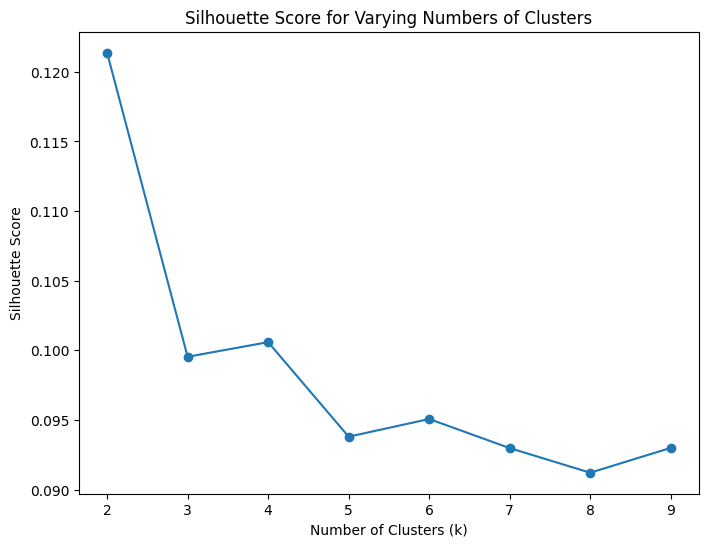

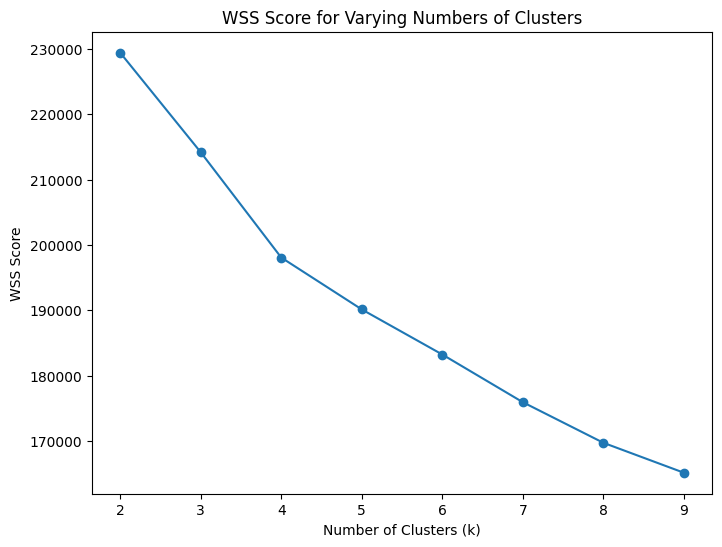

Optimal number of clusters (Silhouette Score): 2
Optimal number of clusters (WSS Score): 9


In [19]:
silhouette_scores = []
wss_scores = []

for k in range(2, 10):
    labels, centroids = kmeans(df_pca, k)
    silhouette_scores.append(silhouette_score(df_pca, labels))
    wss = 0
    for i in range(k):
        cluster_points = df_pca[labels == i]
        wss += np.sum((cluster_points - centroids[i]) ** 2)
    wss_scores.append(wss)
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette Score for Varying Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), wss_scores, marker='o')
plt.title('WSS Score for Varying Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSS Score')
plt.show()
optimal_k_silhouette = np.argmax(silhouette_scores) + 2
optimal_k_wss = np.argmin(wss_scores) + 2
print(f'Optimal number of clusters (Silhouette Score): {optimal_k_silhouette}')
print(f'Optimal number of clusters (WSS Score): {optimal_k_wss}')

# Checking Output

To see how good was our clustering we will use a sample check and t-SNE method.

first randomly select two song from every cluster and see how close these two songs are.

In [22]:
optimal_k = optimal_k_silhouette  # or use optimal_k_wss
labels, centroids = kmeans(df_pca, optimal_k)
for i in range(optimal_k):
    cluster_indices = np.where(labels == i)[0]
    sample_indices = np.random.choice(cluster_indices, 2, replace=False)
    sample_songs = df.iloc[sample_indices]
    print(f"Cluster {i}:")
    print(sample_songs[['track_name', 'track_artist']])
    print()

Cluster 0:
       track_name  track_artist
23023        7830          8451
24384       19254          2668

Cluster 1:
       track_name  track_artist
29735       22335          8333
20738       18568          4742



Using t-SNE reduce dimension of data pointe to 2D and plot it to check how good datapoints are clustered (implementing this part is optional and have extra points)

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_pca)
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=labels, cmap='viridis')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()